In [1]:
import scipy.sparse
import anndata
import pandas as pd
import numpy as np
import io

# function to read in the SComatic output (VCF-like)
def read_vcf(path):
    with open(path, 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    return pd.read_csv(
        io.StringIO(''.join(lines)),
        sep='\t',
        low_memory=False).rename(columns={'#CHROM': 'CHROM'})

def create_ccf_layer(X_zero, called_mutations):
    # Create a new DataFrame CCF_layer by making a copy of X_zero
    CCF_layer = X_zero.copy()

    # Iterate through the rows of called_mutations
    for index, row in called_mutations.iterrows():
        # Split the "Cell_types" and "CCF" values by commas to get lists
        cell_types = row["Cell_types"].split(",")
        ccf_values = [float(value) for value in row["CCF"].split(",")]

        # Iterate through the cell types and corresponding CCF values
        for cell_type, ccf in zip(cell_types, ccf_values):
            # Update the corresponding cell in the CCF_layer DataFrame
            CCF_layer.at[index, cell_type] = ccf

    return CCF_layer

#load the scomatic output and apply some filtering to it
#expects a path to the scomatic file, and a gnomad DF loaded as shown in notebook
#can have verbose=True to print status updates as it goes along
def parse_scomatic(scomatic_path, gnomad, verbose=False):
    if verbose:
        print('reading in scomatic output...')
    df=read_vcf(scomatic_path)

    # Remove sites with multiple alternative alleles
    if verbose:
        print('removing sites with multiple alternatives...')
    df=df[df.N_ALT=='1']
    # Define the filters to be applied
    filters = ['RNA_editing_db', 'Multi-allelic', 'LC_Downstream', 'LC_Upstream', 'Min_cell_types', 'Clustered', 'PoN']
    if verbose:
        print(f'removing unsuitable mutations, filters: {", ".join(filters)}')
    # Check if any of the filters are present in the 'FILTER' column
    mask = df['FILTER'].str.contains('|'.join(filters))
    df = df[~mask]
    # remove rows where ALT contains a pipe - Not sure why this happens!
    if verbose:
        print('removing mutations where ALT contains a pipe...')
    df = df[~df['ALT'].str.contains('|', regex=False)]

    # Add gnomad information
    if verbose:
        print('adding gnomad information...')
    # Get unique ALT
    df['ALT_unique'] = df['ALT'].str.replace(',.*$', '', regex=True)
    # Create VAR_ID
    df['VAR_ID'] = df['CHROM'] + '-' + df['Start'].astype(str) + '-' + df['REF'] + '-' + df['ALT_unique']
    # Merge Gnomad labels
    df = df.merge(gnomad[['VAR_ID', 'LABEL']], how='left', on='VAR_ID', suffixes=('', '_gnomad'))
    df = df.rename(columns={'LABEL': 'Gnomad'})
    # Fill missing values with 'Gnomad < 0.01'
    df['Gnomad'] = df['Gnomad'].fillna('Gnomad < 0.01')
    # Remove likely germline variants (gnomad frequency >1%)
    if verbose:
        print('removing likely germline based on gnomad...')
    df = df[df['Gnomad'] != 'Gnomad >= 0.01']  # This filter removes lots of germline variants

    # make the NC layer (the number of cells callable for a given cell type and mutation)
    if verbose:
        print('making the NC layer...')
    X=df.iloc[:, 25:-3]
    NC_layer=X.applymap(lambda x: x.split("|")[1] if not pd.isna(x) else np.nan)
    def convert_to_int(value):
        if pd.isna(value):
            return value
        else:
            return int(value)
    NC_layer = NC_layer.applymap(convert_to_int)

    # make the CCF layer - where values are NaN (if not callable), 0 if callable but mutation not detected, or CCF value if callable and mutation detected
    # CCF is the fraction of distinct cells carrying the mutation
    if verbose:
        print('constructing CCF...')
    X=df.iloc[:, 25:-3]
    called_mutations=df[['Cell_types','CCF']]
    X_zero = X.where(X.isna(), 0)
    # Call the create_ccf_layer function to create the CCF_layer DataFrame
    CCF_layer = create_ccf_layer(X_zero, called_mutations)

    # reconstruct the number of mutations (NM) by multipltying the CCF by the NC
    if verbose:
        print('making the NM layer...')
    NM_layer = CCF_layer * NC_layer

    #turn into object with an all-zeroes X. squeak in the cell type names somewhat inelegantly
    if verbose:
        print("constructing AnnData...")
    adata = anndata.AnnData(X=scipy.sparse.csr_matrix((NM_layer.shape[1],df.shape[0]), dtype=np.float32),
                            var=df.iloc[:,:25].join(df.iloc[:,-3]))
    adata.obs_names = NM_layer.columns
    #NM and NC as layers
    adata.layers["NM"] = np.round(NM_layer.fillna(0)).T
    adata.layers["NC"] = np.round(NC_layer.fillna(0)).T

    return adata

#add up observations in an adata based on a grouping variable in .obs
#sourced from https://discourse.scverse.org/t/group-sum-rows-based-on-jobs-feature/371/4
#modded a bit for our purposes - we don't care about X but care about the layers
def sum_by(adata: anndata.AnnData, col: str) -> anndata.AnnData:
    adata.strings_to_categoricals()
    assert pd.api.types.is_categorical_dtype(adata.obs[col])

    indicator = pd.get_dummies(adata.obs[col])

    #create an X of all zeroes of the appropriate size, like the scomatic object earlier
    bdata = anndata.AnnData(
        scipy.sparse.csr_matrix((indicator.shape[1],adata.shape[1])),
        var=adata.var,
        obs=pd.DataFrame(index=indicator.columns)
    )
    #we actually care about the layer part
    for layer in ["NC", "NM"]:
        bdata.layers[layer] = indicator.values.T @ adata.layers[layer]
    return bdata

#turn the NM and NC info in the parsed scomatic object into CCF
#also filter the mutations, requiring at least NC_threshold non-zero fraction
def get_CCF(adata, NC_threshold=1):
    #avoid modifying original object
    adata = adata.copy()
    #require that at least NC_threshold fraction cell types have the mutations callable
    mask = np.sum(adata.layers["NC"]>0, axis=0)/adata.shape[0] >= NC_threshold
    adata = adata[:, mask]
    #require that some cell types actually have mutated counts
    mask = np.sum(adata.layers["NM"], axis=0)>0
    adata = adata[:, mask]
    #can now compute CCF. this introduces NANs where NC is 0, which is good, that's by design
    ccf = pd.DataFrame(adata.layers["NM"]/adata.layers["NC"], index=adata.obs_names, columns=adata.var_names)
    return ccf

Load gnomAD data, which will be used to identify common mutations among the spotted ones. The assumption is that common mutations are more likely to be germline, i.e. already present at the beginning of the donor's life, and don't interest us in our attempts to reconstruct lineage relationships.

In [2]:
# Read in gnomAD (https://gnomad.broadinstitute.org/) data and format it.
# This will be used to judge whether a mutation is common in the general population - which are therefore likely germline and should be removed
gnomad = pd.read_csv('/lustre/scratch126/cellgen/team205/jc48/jupyter/SComatic/gnomad/gnomad.hg38.snps.MAF_1_Perc.txt.gz', compression='gzip', sep='\t',low_memory=False)
gnomad = gnomad.rename(columns={'#Chr': 'Chr'})
gnomad['Chr'] = 'chr'+gnomad['Chr'].astype(str)
gnomad['VAR_ID'] = gnomad['Chr'] + '-' + gnomad['Start'].astype(str) + '-' + gnomad['Ref'] + '-' + gnomad['Alt']
gnomad['LABEL'] = 'Gnomad >= 0.01'

Load the SComatic output and perform some filtering on it:
- require the alternate allele to be a clearly defined single nucleotide
- remove mutations based on QC filters consulted with SComatic's author
- remove common mutations based on gnomAD

The mutations that survive will have their `NC` (number of callable cells within each cell type) and `NM` (number of mutated cells within each cell type) reported as layers of an AnnData object. All this is accomplished by `parse_scomatic()`, which takes the path to the SComatic output and a copy of the gnomAD data frame loaded earlier.

Seeing how we have both GEX and ATAC for this donor, load the two modalities separately, and flag the AnnData variables with the modality. Then concatenate the two objects on the cell type axis, getting both modalities together.

In [3]:
scomatic_pipeline_outdir = "/lustre/scratch126/cellgen/team205/sharedData/jc48/23-03-16-scomatic"
donor = "Hst41"

holder = []
for modality in ["GEX", "ATAC"]:
    scomatic_path = f'{scomatic_pipeline_outdir}/{donor}-{modality}/Step4_VariantCalling/{donor}.calling.step2.intersect.tsv'
    holder.append(parse_scomatic(scomatic_path, gnomad))
    holder[-1].var_names = [modality+"-"+i for i in holder[-1].var_names]

adata = anndata.concat(holder, join="inner", axis=1)

/opt/conda/envs/teichlab/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


At this stage, the object is ready for analysis. Let's follow James's example and only show the relationship of some cell types.

Extracting these cell types involves the `.obs` of the object being populated with an alternate annotation, the translation to which can be found in a helper CSV file included in the folder. Using `.map()` based on data frames for performing these sort of operations is generally rather convenient, so it's included here in case the syntax is of use to someone.

While doing this, may as well demonstrate the strengths of going for the `NM`/`NC` layer approach. Let's collapse all cells in the neural coarse group into a single cell type while retaining the cardiomyocytes separated. We can just add up appropriate entries in the layers and we're good.

In [4]:
translation = pd.read_csv("cell_type_translation.csv", index_col=0)
#the cell types within this scomatic output have the donor appended at the end
#while useful for scomatic purposes, not so much here - strip it out
#of note, this scomatic was ran before -s started getting automatically turned to _s in cell type names
adata.obs_names = [i.replace("-"+donor, "") for i in adata.obs_names]
for col in translation.columns:
    adata.obs[col] = adata.obs_names.map(translation[col])

mask = (adata.obs['coarse'].isin(['Cardiomyocytes','Neural'])) & (~adata.obs_names.str.contains('Cycling'))
# Subset the AnnData object using the mask
tmp_adata = adata[mask]

In [5]:
tmp_adata.obs['sum_by'] = tmp_adata.obs_names
tmp_adata.obs['sum_by'][tmp_adata.obs['coarse'] == "Neural"] = "Neural"
tmp_adata = sum_by(tmp_adata, col="sum_by")

Trying to set attribute `.obs` of view, copying.
... storing 'coarse' as categorical
... storing 'mid' as categorical
... storing 'sum_by' as categorical
... storing 'CHROM' as categorical
... storing 'REF' as categorical
... storing 'ALT' as categorical
... storing 'FILTER' as categorical
... storing 'Cell_types' as categorical
... storing 'Up_context' as categorical
... storing 'Down_context' as categorical
... storing 'N_ALT' as categorical
... storing 'Dp' as categorical
... storing 'Nc' as categorical
... storing 'Bc' as categorical
... storing 'Cc' as categorical
... storing 'VAF' as categorical
... storing 'CCF' as categorical
... storing 'BCp' as categorical
... storing 'CCp' as categorical
... storing 'Rest_BC' as categorical
... storing 'Rest_CC' as categorical
... storing 'Fisher_p' as categorical
... storing 'Cell_type_Filter' as categorical
... storing 'INFO' as categorical
... storing 'ALT_unique' as categorical


At this stage the `CCF` (fraction of mutated cells) can be computed via a helper function `get_CCF()`, for each mutation and cell type. Mutations with zero NCs in a cell type will lead to a `NaN` value, and it's desirable to control the rate of that happening. The `NC_threshold` parameter requires at least the provided fraction of non-zero `NC` values for a mutation across the cell types. A second filter is subsequently applied - mutations where no `NM`s are detected are removed, as they don't really tell us anything interesting.

In [6]:
ccf = get_CCF(tmp_adata, NC_threshold=0.8)

<ipython-input-1-6128fc37ab9d>:145: RuntimeWarning: invalid value encountered in true_divide
  ccf = pd.DataFrame(adata.layers["NM"]/adata.layers["NC"], index=adata.obs_names, columns=adata.var_names)


At this point we're ready to do some proof of concept clustermaps. Do a little plotting configuration, including a nice custom colour map with NaNs as grey, and then values going from blue to red as the `CCF` increases.

In [7]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# cmap
# grey is NaN (-1), blue is callable and absent (0), red is callable and present (>0)
light_grey = (0.9, 0.9, 0.9)  # RGB values for a lighter grey color
colors_light_grey = [light_grey, "blue", "red"]
cmap = LinearSegmentedColormap.from_list("custom_colormap", colors_light_grey)

Fill in the `NaN`s with -1 for the clustermap to work. Behold, cell types grouped on mutation profiles!

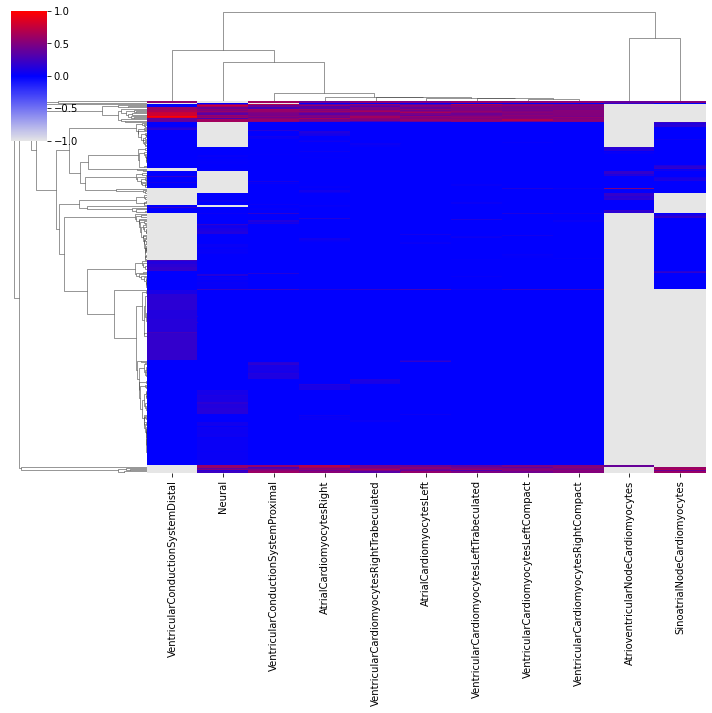

In [8]:
sns.clustermap(ccf.fillna(-1).T, yticklabels=False, cbar=True, cmap=cmap)

This is with a continuous `CCF` value. It may be desirable to perform a thresholding on it, getting a 0/1 outcome. The code snippet below performs it, while respecting the location of `NaN`s stemming from absent mutations.

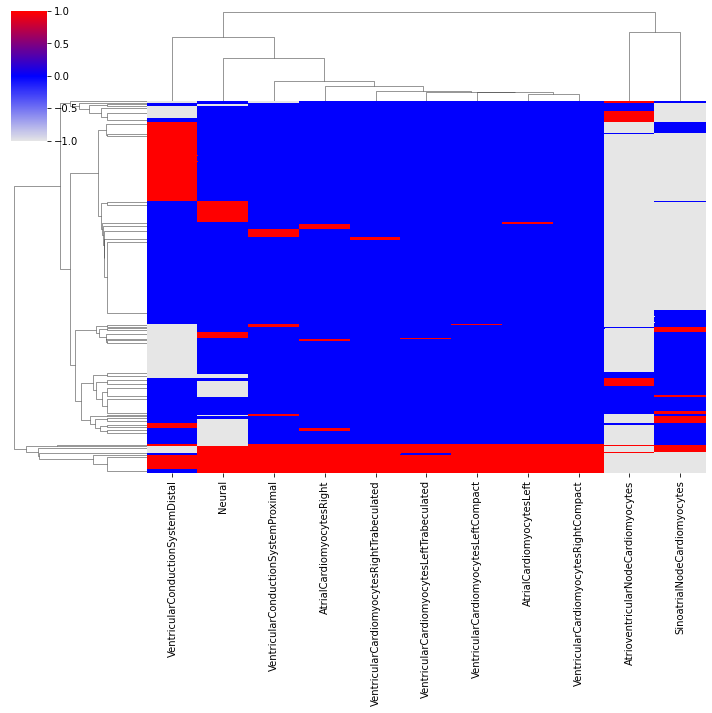

In [9]:
#mask the CCF based on a threshold. turn it to an integer so that it's 0/1 rather than true/false
#then reinstate the NANs in the locations where they were originally located
thresh = 0.1
ccf_binarised = (ccf >= thresh).astype(int)
ccf_binarised[np.isnan(ccf)] = np.nan

sns.clustermap(ccf_binarised.fillna(-1).T, yticklabels=False, cbar=True, cmap=cmap)

We can now construct a phylogenetic tree. James had to move the analysis to R because appropriate algorithms were missing from python.

The analysis requires phangorn, which by default requires a newer R than what is the JupyterHub default. However, there are archival versions of the package available from CRAN. If you wish to use the default JupyterHub R with rpy2 for the purpose of the phylogenetic tree, open R from a JupyterHub terminal and run the following command to install an archival phangorn:
```R
devtools::install_version("phangorn", version = "2.7.1", repos = "http://cran.r-project.org")
```

In [10]:
%load_ext rpy2.ipython

/opt/conda/envs/teichlab/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:15: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [11]:
%%R

library(phangorn)
library(ape)

# Custom Hamming distance function that handles NAs (by not computing distance at a position unless both cell types are not NA)
hamming_na <- function(x, y) {
  non_na_positions <- !is.na(x) & !is.na(y)
  sum(x[non_na_positions] != y[non_na_positions])
}

R[write to console]: Loading required package: ape



Let's feed the binarised matrix into R and construct the phylogenetic tree. On top of building the tree with a Hamming metric variant that accounts for missing values, the snippet then performs 100 bootstraps by randomly leaving out mutations and reporting how often a given bifurcation is present in the resulting trees.

Running bootstraps:       100 / 100
Calculating bootstrap values... done.


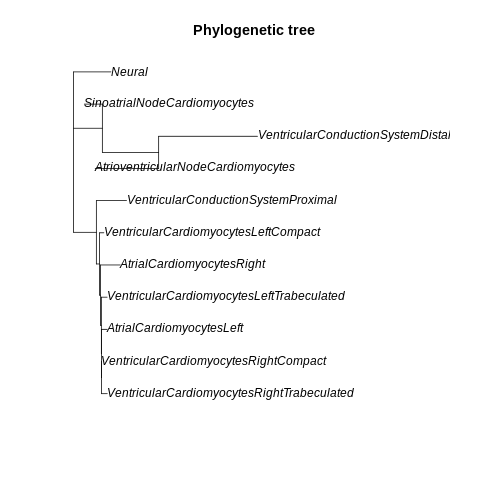

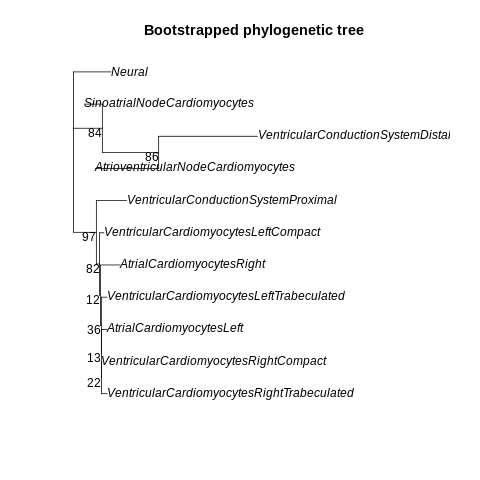

In [12]:
%%R -i ccf_binarised

#the R code wants the data transposed relative to what the python code does
mat = t(ccf_binarised)

#make distance matrix
dm <- as.dist(outer(1:ncol(mat), 1:ncol(mat), Vectorize(function(i, j) hamming_na(mat[ , i], mat[ , j]))))

#construct tree
tree <- NJ(dm)
#add the col names of mat_t as tip labels to the tree
tip_labels=colnames(mat)
tree$tip.label <- tip_labels

#plot tree
plot(root(tree, outgroup='Neural'))
title("Phylogenetic tree")

#perform bootstrapping
bstrees <- boot.phylo(tree, t(mat), B = 100, 
                      FUN = function(x) NJ(dist(x, method = "binary")), trees = TRUE)$trees
#plot bootstrapped tree
plotBS(root(tree, outgroup='Neural'), bstrees, "phylogram", p=0)
title("Bootstrapped phylogenetic tree")

It's possible to construct a consensus phylogenetic tree across multiple donors. In that case, it's likely that you'll want to save the binarised matrix you created. As it's a simple data frame, it can just be `.to_csv()`'d.

In [13]:
ccf_binarised.to_csv("test.csv")

This repository folder holds such exports of binarised matrices generated for a few different donors. We can load them up and concatenate them into a single matrix on cell type.

In [14]:
dfs = []
for donor in ["C87", "C92", "C98", "Hst33", "Hst41"]:
    dfs.append(pd.read_csv(donor+".csv", header=0, index_col=0))
    #store the donor ID in the mutation name
    dfs[-1].columns = [donor+"_"+i for i in dfs[-1].columns]
master_df = pd.concat(dfs, axis=1)

At this point we can feed the concatenated matrix into the R snippet from earlier. Note the variable holding it is called `master_df` rather than `ccf_binarised`, so we need to slightly adjust the code to pass and use it.

Running bootstraps:       100 / 100
Calculating bootstrap values... done.


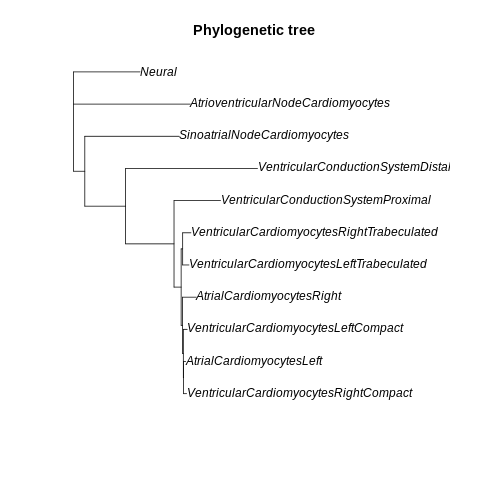

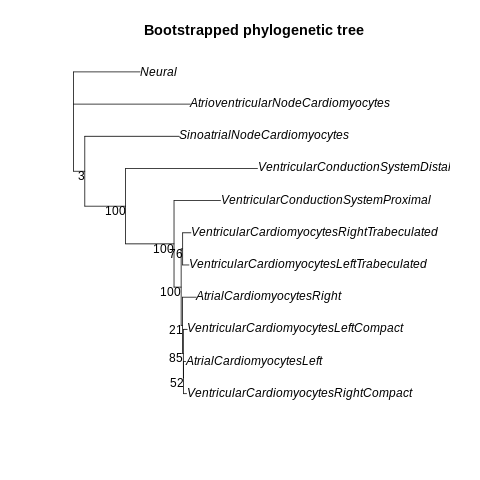

In [15]:
%%R -i master_df

#the R code wants the data transposed relative to what the python code does
mat = t(master_df)

#make distance matrix
dm <- as.dist(outer(1:ncol(mat), 1:ncol(mat), Vectorize(function(i, j) hamming_na(mat[ , i], mat[ , j]))))

#construct tree
tree <- NJ(dm)
#add the col names of mat_t as tip labels to the tree
tip_labels=colnames(mat)
tree$tip.label <- tip_labels

#plot tree
plot(root(tree, outgroup='Neural'))
title("Phylogenetic tree")

#perform bootstrapping
bstrees <- boot.phylo(tree, t(mat), B = 100, 
                      FUN = function(x) NJ(dist(x, method = "binary")), trees = TRUE)$trees
#plot bootstrapped tree
plotBS(root(tree, outgroup='Neural'), bstrees, "phylogram", p=0)
title("Bootstrapped phylogenetic tree")